In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

import os
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

In [2]:
n_epoch = 20
batch_size = 16
lr = 1e-4
betas = (0.9, 0.999)

input_PATH = "Data/Geoid/results_20k_zero/input.npy"
output_PATH = "Data/Geoid/results_20k_zero/output.npy"

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Current device is ",device)

# Fit the MinMaxScalar for output data
output_for_Scalar = np.load(output_PATH)
scaler = MinMaxScaler()
scaler.fit(output_for_Scalar)
print("Fit the output range to [0,1] using MinMaxscaler")


# Fit another MinMaxScalar for input data
input_for_Scalar = np.load(input_PATH)
scaler_input = StandardScaler()
scaler_input.fit(input_for_Scalar)
print("Fit the input range to [0,1] using MinMaxscaler")


# make results determinstic
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Current device is  cpu
Fit the output range to [0,1] using MinMaxscaler
Fit the input range to [0,1] using MinMaxscaler


In [3]:
class KMNIST(Dataset):
    
    def __init__(self, input_path, output_path):
        # Load the input and output
        input_data = scaler_input.transform(np.load(input_path))
        output_data = scaler.transform(np.load(output_path))
        
        self.input = input_data
        self.output = output_data
        
    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        input_item = self.input[index]
        output_item = self.output[index]
        
        return input_item, output_item

In [4]:
testingAndValidation_split = 0.2
validation_split = 0.1

# Load the input and output as a complete dataset

geoid_dataset = KMNIST(
    input_PATH,
    output_PATH,
)


# Creating data indices for training, testing and validation splits
# Reference: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
geoid_dataset_size = len(geoid_dataset)
geoid_indices = list(range(geoid_dataset_size))

geoid_training_testing_split = int(np.floor(testingAndValidation_split * geoid_dataset_size))
geoid_testing_validation_split = int(np.floor(validation_split * geoid_dataset_size))

np.random.shuffle(geoid_indices)
geoid_train_indices, geoid_val_indices ,geoid_test_indices = geoid_indices[geoid_training_testing_split:], geoid_indices[:geoid_testing_validation_split], geoid_indices[geoid_testing_validation_split:geoid_training_testing_split] 

# Creating data samplers
geoid_train_sampler = SubsetRandomSampler(geoid_train_indices)
geoid_test_sampler = SubsetRandomSampler(geoid_test_indices)
geoid_valid_sampler = SubsetRandomSampler(geoid_val_indices)

geoid_train_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_train_sampler,
)

geoid_test_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_test_sampler,
)

geoid_validation_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_valid_sampler,
)

'''

generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset, validation_dataset = random_split(geoid_dataset, [0.8,0.1,0.1], generator = generator)

geoid_train_loader = DataLoader(
    dataset=train_dataset,
    batch_size = batch_size,
    shuffle = True
)

geoid_test_loader = DataLoader(
    dataset=test_dataset,
    batch_size = batch_size,
    shuffle = False
)

geoid_validation_loader = DataLoader(
    dataset=validation_dataset,
    batch_size = batch_size,
    shuffle = False
)

'''

print("Training data, testing data and validation data is spilt into 8:1:1")

Training data, testing data and validation data is spilt into 8:1:1


In [5]:
'''
train_input, train_output = next(iter(geoid_train_loader))

print(f"Feature batch shape: {train_input.size()}")
print(f"Labels batch shape: {train_output.size()}")

test_index = 1
train_input_batch_sample = train_input[test_index]
train_output_batch_sample = train_output[test_index]

print(f"Input: {train_input_batch_sample}")
print(f"Output: {train_output_batch_sample}")
'''

'\ntrain_input, train_output = next(iter(geoid_train_loader))\n\nprint(f"Feature batch shape: {train_input.size()}")\nprint(f"Labels batch shape: {train_output.size()}")\n\ntest_index = 1\ntrain_input_batch_sample = train_input[test_index]\ntrain_output_batch_sample = train_output[test_index]\n\nprint(f"Input: {train_input_batch_sample}")\nprint(f"Output: {train_output_batch_sample}")\n'

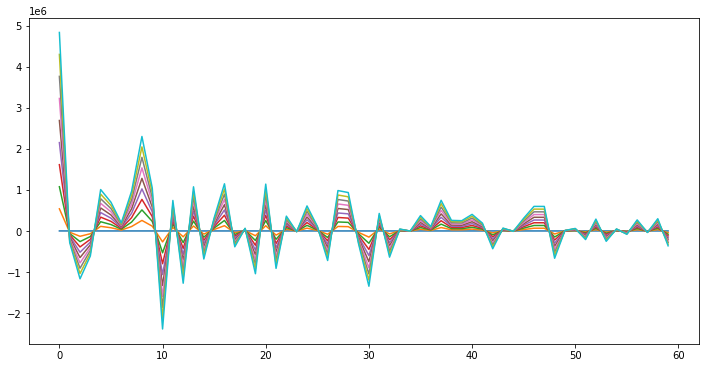

In [6]:
voutput = np.load(output_PATH)

nmodels, _ = voutput.shape

plt.figure(figsize=(12, 6))

# Just plot every 100th model output and output to observe the pattern
for i in range(1, nmodels, 2000):

    plt.plot(voutput[i, :])

plt.show()

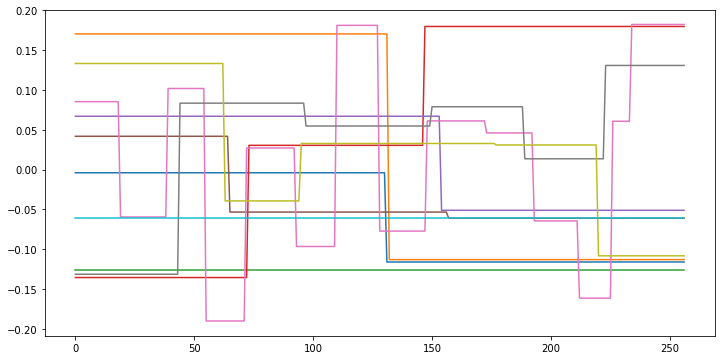

In [7]:
vinput = np.load(input_PATH)

nmodels, _ = vinput.shape

plt.figure(figsize=(12, 6))

# Just plot every 100th model input and output to observe the pattern
for i in range(1, nmodels, 2000):

    plt.plot(vinput[i, :])

plt.show()

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()    
        self.fc1 = nn.Linear(257, 1028)
        
        self.fc2 = nn.Linear(1028, 514)   
        self.fc3 = nn.Linear(514, 200)
        self.fc4 = nn.Linear(200, 160)
        self.fc5 = nn.Linear(160, 120)
        self.fc6 = nn.Linear(120, 80)
        self.fc7 = nn.Linear(80, 120)
        
        self.fc8 = nn.Linear(120, 60)
        
        self.relu = nn.ReLU()
        self.drop = nn.Dropout()
    
    def forward(self, x):                              
        x = x.to(torch.float32)
        
        out = self.fc1(x)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        
        out = self.fc4(out)
        out = self.relu(out)
        
        out = self.fc5(out)
        out = self.relu(out)
        
        out = self.fc6(out)
        out = self.relu(out)
        
        out = self.fc7(out)
        out = self.relu(out)
        
        out = self.fc8(out)
        
        return out

In [9]:
def train(model, train_loader, val_loader, device, optimizer, n_epoch):
    
    criterion = nn.MSELoss()
    
    minimum_validation_loss = 10000000
    best_model_index = -1
    
    running_loss_list = []
    validation_loss_list = []

    # n_epoch times of iterations
    for epoch in range(n_epoch):

        running_loss = 0.0

        model.train()
        
        for data in train_loader:
            # get a batch of inputs and labels
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # Get output features, calculate loss and optimize
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float())
            
            loss.backward()
            optimizer.step()

            # Add to the total training loss
            running_loss += loss.item()

        # print some statistics
        print(epoch+1,"epochs have finished")
        print("Current training loss is ",running_loss)
        running_loss_list.append(running_loss)
        running_loss = 0.0

        # Valiadation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            valid_loss = 0.0
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                
                # Get output features and calculate loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # If the loss value is less than 0.02, we consider it being accurate
                for j in range(len(labels)):
                    single_loss = criterion(outputs[j], labels[j])
                    if single_loss.item() <= 0.02:
                        correct += 1
                    total += 1

                # Add to the validation loss
                valid_loss += loss.item()

            # Calculate valiadation accuracy and print Validation statistics
            print("Validation loss for this epoch is",valid_loss)
            print("Validation Accuracy for this epoch is", 100*correct//total)
            validation_loss_list.append(valid_loss)

        # Update the statistics for the best model
        if valid_loss <= minimum_validation_loss:
            minimum_validation_loss = valid_loss

            # Store the best models
        
            PATH = 'geoid_model_best.pth'

            torch.save(model.state_dict(), PATH)
            print("This model is now saved to Path:",PATH)
            
            best_model_index = epoch
            
        print()
    
    # Training finished, print the statistics for the best model
    print('Finished Training')
    print("Best model has a validation loss of ",minimum_validation_loss)
    print("Best model is in epoch ",best_model_index+1)
    
    # Plot the Training loss and validation loss during training
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(running_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss in each epoch')

    plt.subplot(2, 1, 2)
    plt.plot(validation_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss in each epoch')
    
    plt.subplots_adjust(hspace=1)

    plt.show()

In [10]:
model = Net().to(device)
#optimizer = Minimizer(model.parameters(), method='bfgs', disp=2, max_iter = 2)
#optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

1 epochs have finished
Current training loss is  107.69209608063102
Validation loss for this epoch is 10.543128744055181
Validation Accuracy for this epoch is 27
This model is now saved to Path: geoid_model_best.pth

2 epochs have finished
Current training loss is  85.02053295448422
Validation loss for this epoch is 10.462803083753482
Validation Accuracy for this epoch is 27
This model is now saved to Path: geoid_model_best.pth

3 epochs have finished
Current training loss is  84.5542030222714
Validation loss for this epoch is 10.504739394548931
Validation Accuracy for this epoch is 27

4 epochs have finished
Current training loss is  84.28959204442799
Validation loss for this epoch is 10.469575786243928
Validation Accuracy for this epoch is 27

5 epochs have finished
Current training loss is  84.10237727873027
Validation loss for this epoch is 10.393304464586196
Validation Accuracy for this epoch is 28
This model is now saved to Path: geoid_model_best.pth

6 epochs have finished
Curre

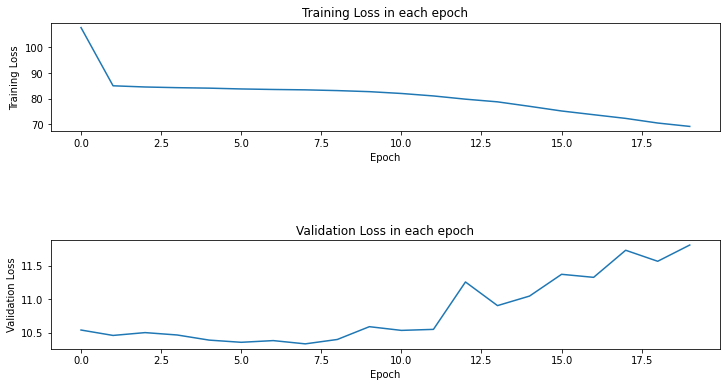

'\ncriterion = nn.MSELoss()\n\ndef closure():\n    for data in geoid_train_loader:\n        # get a batch of inputs and labels\n        inputs, labels = data[0].to(device), data[1].to(device)\n        \n    optimizer.zero_grad()\n    output = model(inputs)\n    loss = criterion(output.float(), labels.float())\n    \n    return loss\n\nloss = optimizer.step(closure)\nprint(loss.item())\n'

In [11]:
train(model, geoid_train_loader, geoid_validation_loader, device, optimizer, n_epoch)
'''
criterion = nn.MSELoss()

def closure():
    for data in geoid_train_loader:
        # get a batch of inputs and labels
        inputs, labels = data[0].to(device), data[1].to(device)
        
    optimizer.zero_grad()
    output = model(inputs)
    loss = criterion(output.float(), labels.float())
    
    return loss

loss = optimizer.step(closure)
print(loss.item())
'''

In [12]:
def test(model, test_loader, device):

    # Load the model from the input model_path  
    #model.load_state_dict(torch.load(model_path))

    correct = 0
    total = 0
    criterion = nn.MSELoss()
    total_loss = 0.0
    
    best_worst_error_list = [1000000, 0]
    best_worst_input_list = [0, 0]
    best_worst_output_list = [0, 0]
    best_worst_predicted_list = [0, 0]
    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
                
            # Get output features and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
                
            # If the loss value is less than 0.02, we consider it being accurate
            for j in range(len(labels)):
                single_loss = criterion(outputs[j], labels[j])
                if single_loss.item() <= 0.02:
                    correct += 1
                total += 1
                
                # Record worst error
                if single_loss.item() > best_worst_error_list[1]:
                    best_worst_error_list[1] = single_loss.item()
                    best_worst_input_list[1] = inputs[j]
                    best_worst_output_list[1] = labels[j]
                    best_worst_predicted_list[1] = outputs[j]
                    
                # Record best error
                if single_loss.item() < best_worst_error_list[0]:
                    best_worst_error_list[0] = single_loss.item()
                    best_worst_input_list[0] = inputs[j]
                    best_worst_output_list[0] = labels[j]
                    best_worst_predicted_list[0] = outputs[j]
                    

            # Add to the validation loss
            total_loss += loss.item()

    # Calculate the overall accuracy and return the accuracy and test loss
    print("Total loss for the model is",total_loss)
    print("Accuracy for the model is", 100*correct//total)
    print()
    
    # Draw some plots for the best and the worst error
    print("Best model has a error of ", best_worst_error_list[0])
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case input")
    plt.plot(best_worst_input_list[0].detach().numpy())

    plt.show()
    
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case plot")
    plt.plot(scaler.inverse_transform([best_worst_output_list[0].detach().numpy()])[0], label='Data Output')
    plt.plot(scaler.inverse_transform([best_worst_predicted_list[0].detach().numpy()])[0], label='Predicted Output')
    plt.legend()

    plt.show()
    
    
    print("Worst model has a error of ", best_worst_error_list[1])
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case input")
    plt.plot(best_worst_input_list[1].detach().numpy())

    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case plot")
    plt.plot(scaler.inverse_transform([best_worst_output_list[1].detach().numpy()])[0], label='Data Output')
    plt.plot(scaler.inverse_transform([best_worst_predicted_list[1].detach().numpy()])[0], label='Predicted Output')
    plt.legend()

    plt.show()
    
    #return 100*correct//total, total_loss

Total loss for the model is 65.96316323501378
Accuracy for the model is 37

Best model has a error of  3.6875915525022633e-06


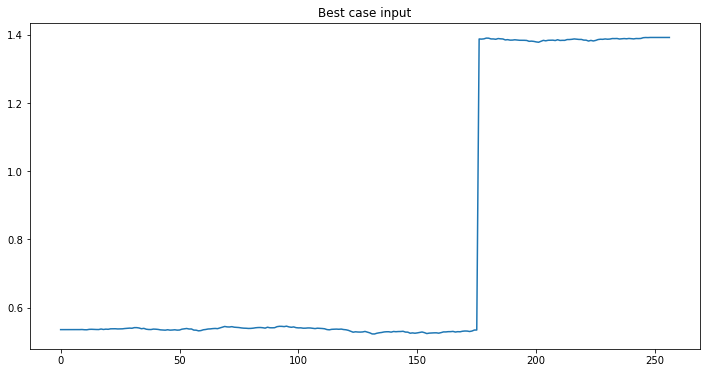

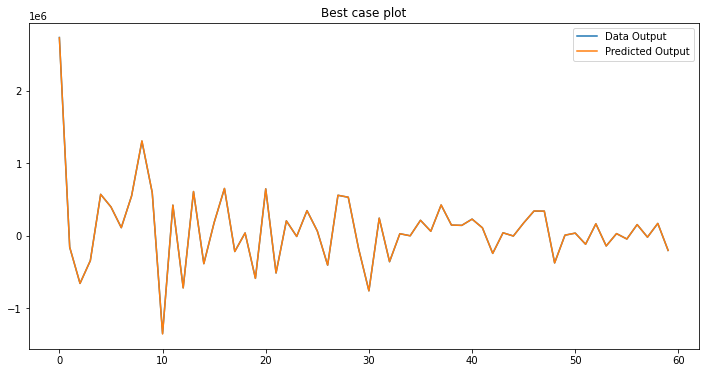

Worst model has a error of  0.42119666464123895


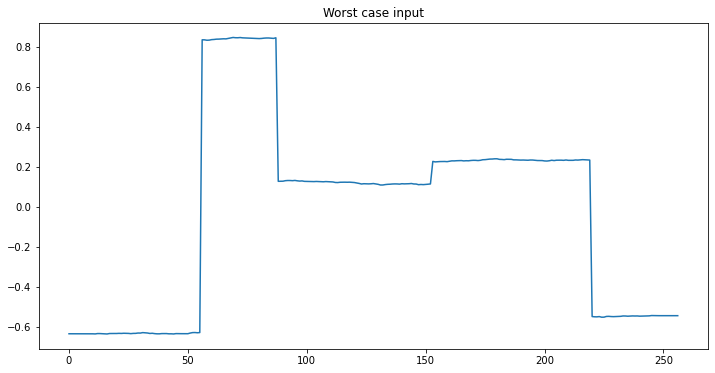

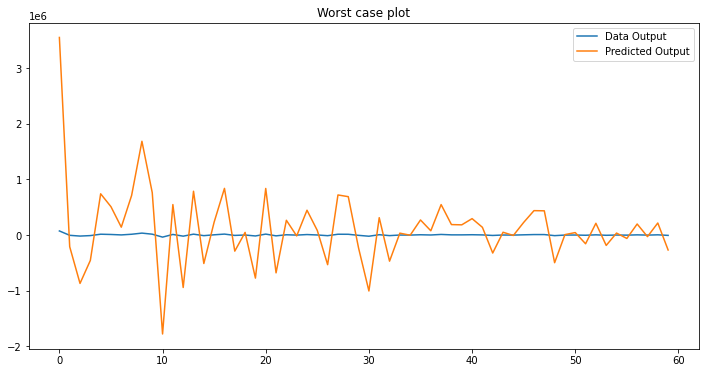

In [13]:
# Print Accuracy for the training data using the current model (Not the best one)
test(model, geoid_train_loader, device)

Total loss for the model is 11.351084872699671
Accuracy for the model is 28

Best model has a error of  6.221092689657425e-06


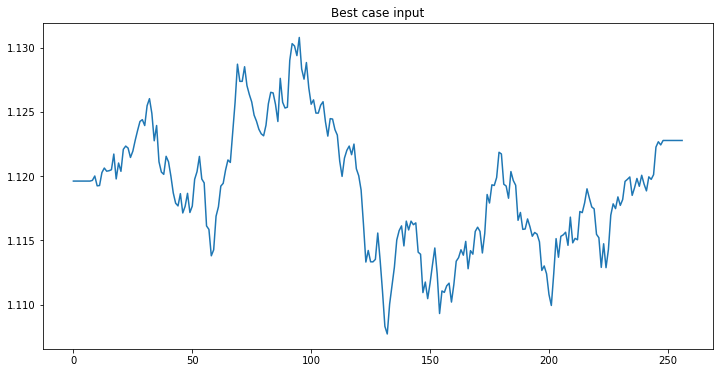

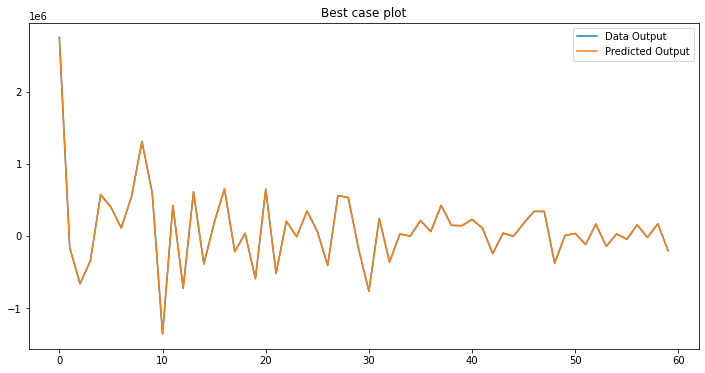

Worst model has a error of  0.6739204325882174


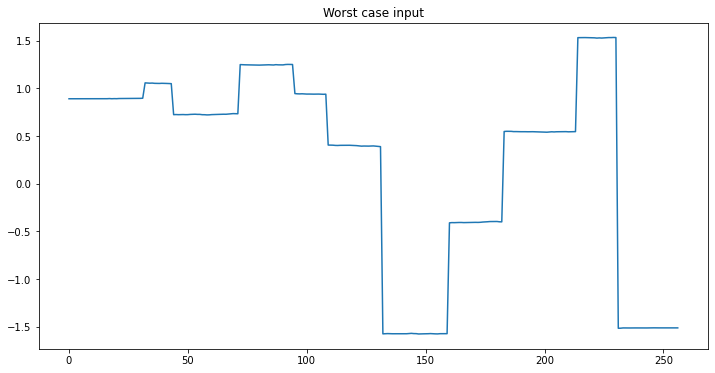

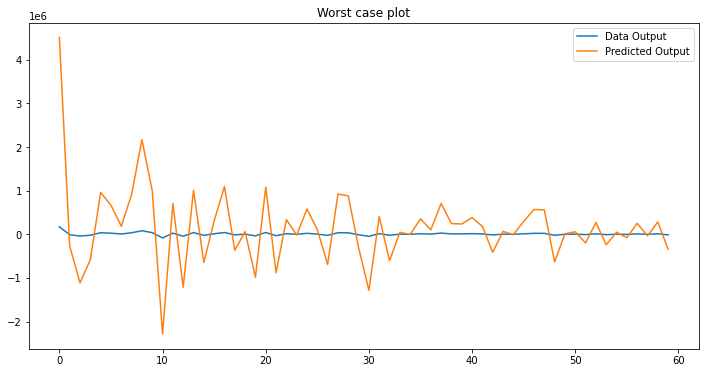

In [14]:
# Print Accuracy for the Testing data using the current model (Not the best one)
test(model, geoid_test_loader, device)

Total loss for the model is 82.5893484896019
Accuracy for the model is 28

Best model has a error of  6.6120557274718835e-06


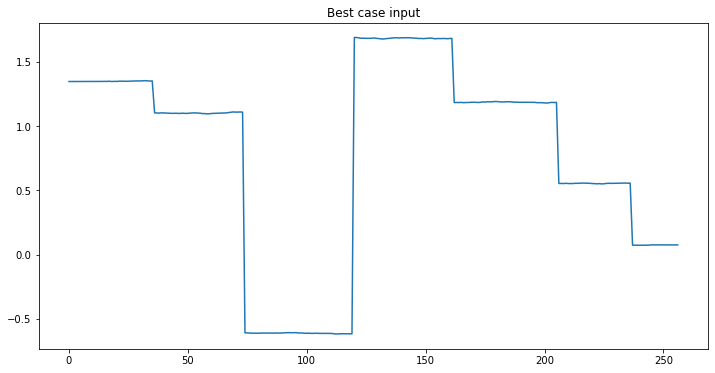

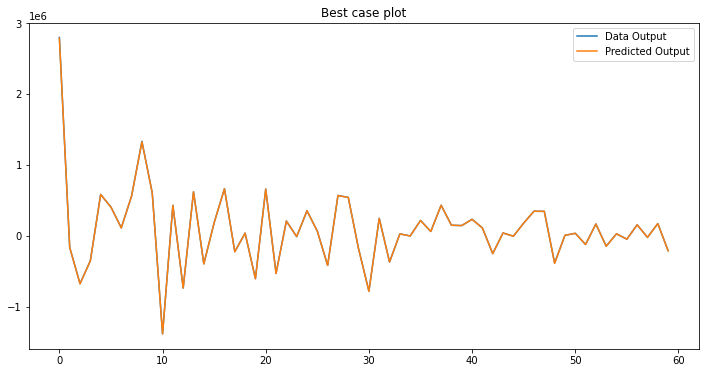

Worst model has a error of  0.2997681392373315


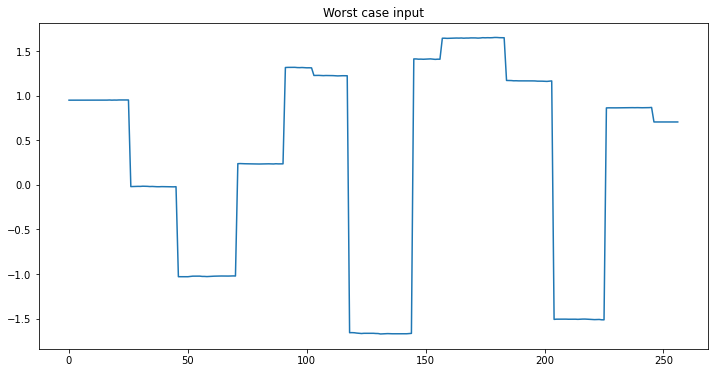

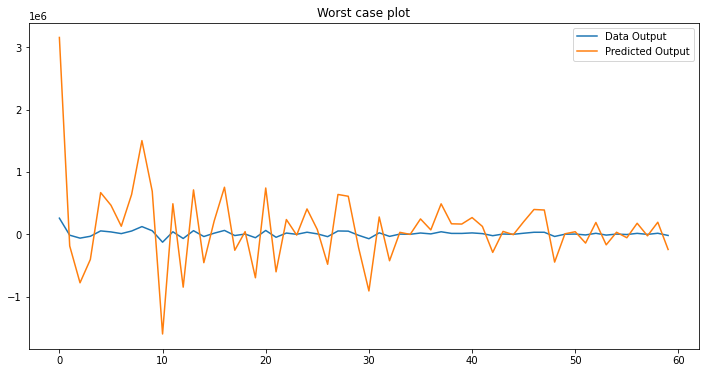

In [15]:
# Print Accuracy for the training data using the best one
model.load_state_dict(torch.load('geoid_model_best.pth'))
test(model, geoid_train_loader, device)

Total loss for the model is 10.044427221865506
Accuracy for the model is 29

Best model has a error of  1.5253432307309931e-05


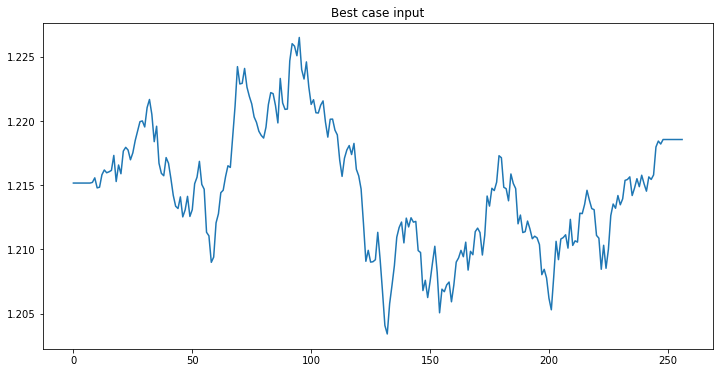

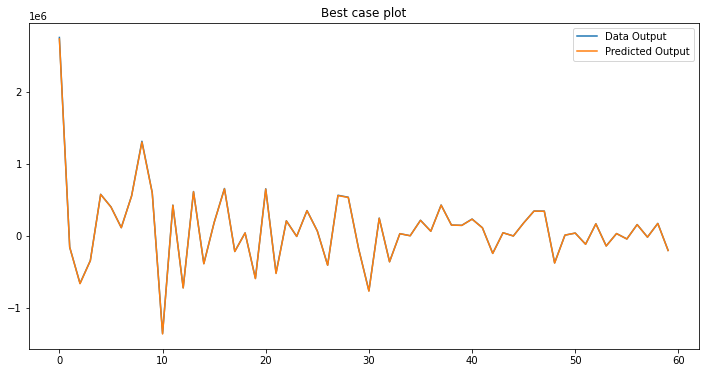

Worst model has a error of  0.32598822835407226


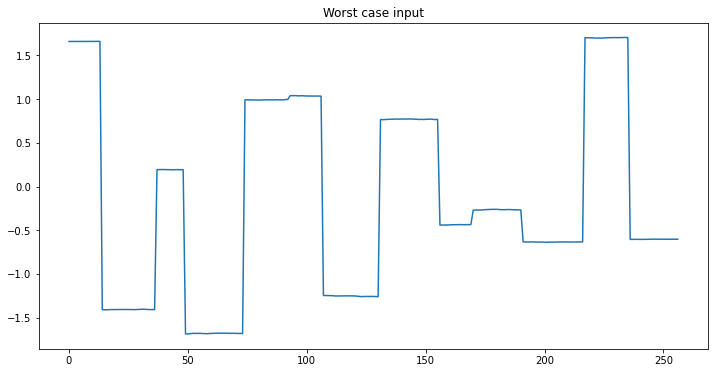

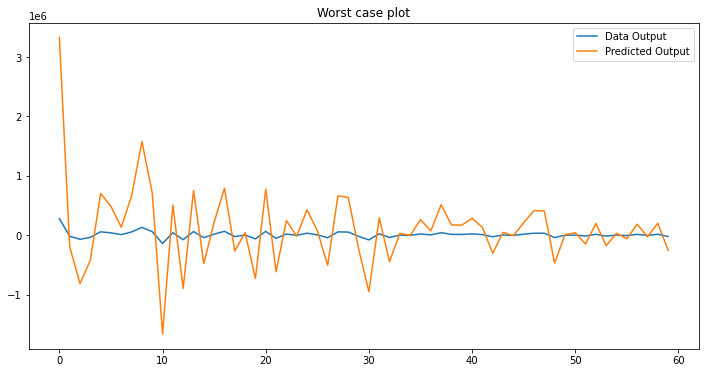

In [16]:
# Print Accuracy for the Testing data using the Best model
test(model, geoid_test_loader, device)

Loss between predicted output and actual output (Both Normalised) 0.06100782467953226


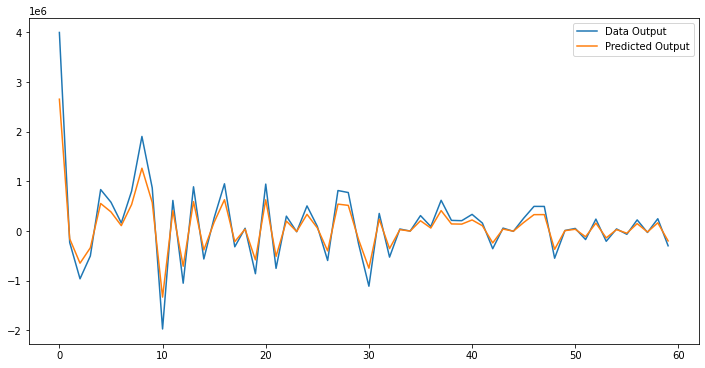

Loss between predicted output and actual output (Both Normalised) 0.05918249465269632


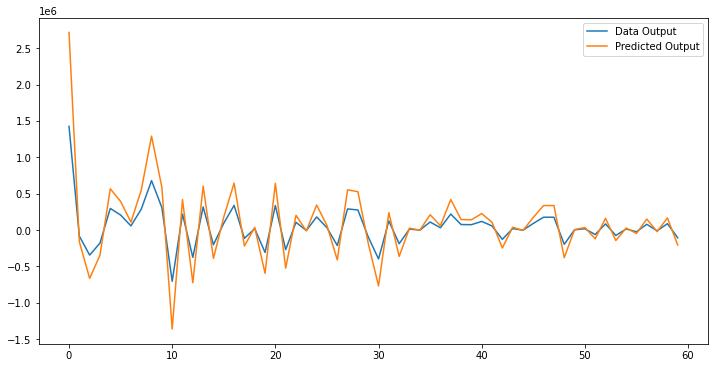

Loss between predicted output and actual output (Both Normalised) 0.0026540107142274073


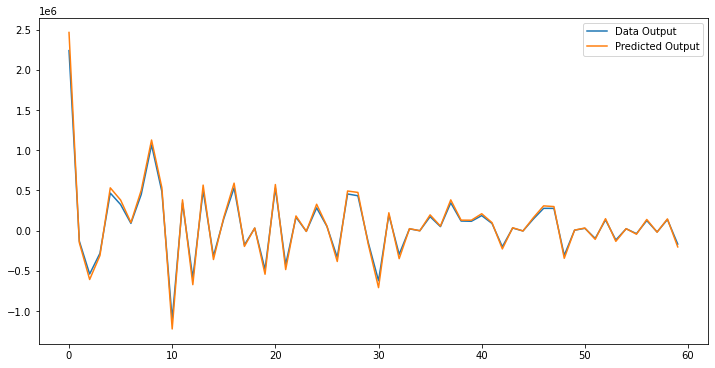

Loss between predicted output and actual output (Both Normalised) 0.14817480051301898


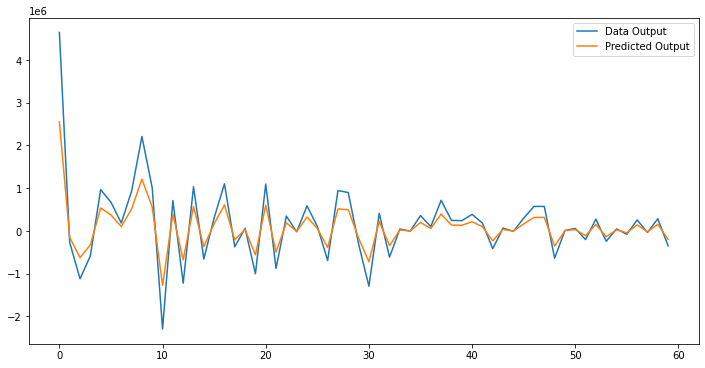

Loss between predicted output and actual output (Both Normalised) 0.029505466660209933


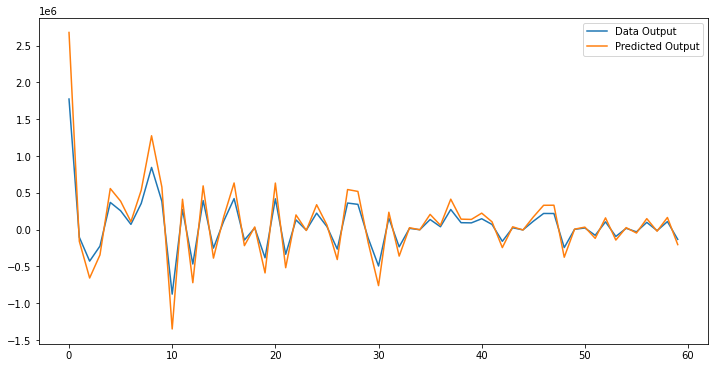

Loss between predicted output and actual output (Both Normalised) 0.1722155492904684


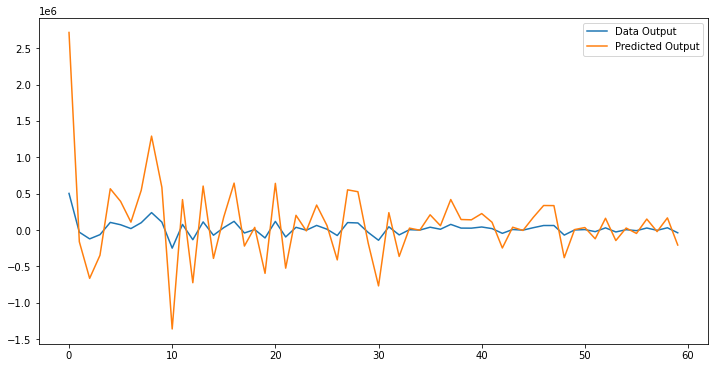

Loss between predicted output and actual output (Both Normalised) 0.07119435928728364


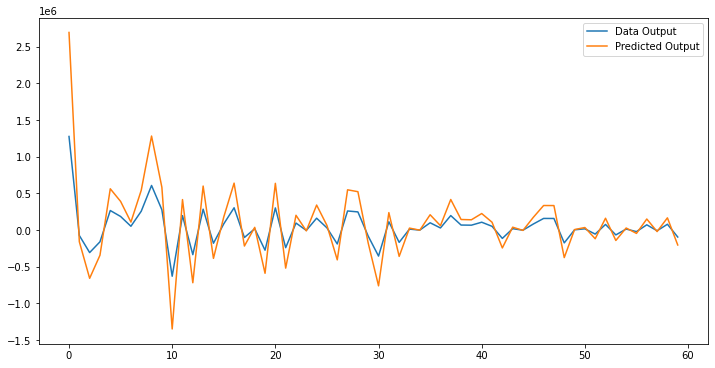

Loss between predicted output and actual output (Both Normalised) 0.006674803975772596


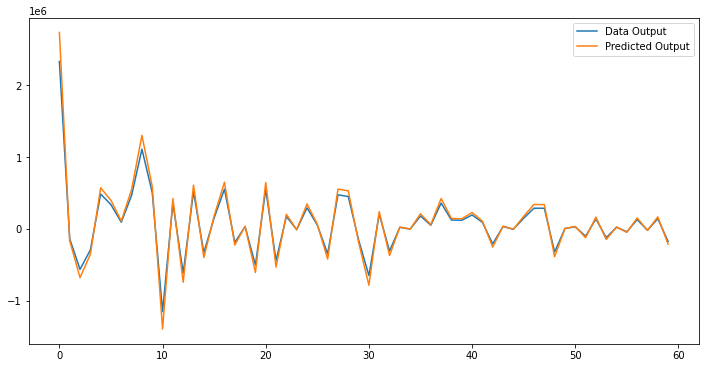

Loss between predicted output and actual output (Both Normalised) 0.011562165681521066


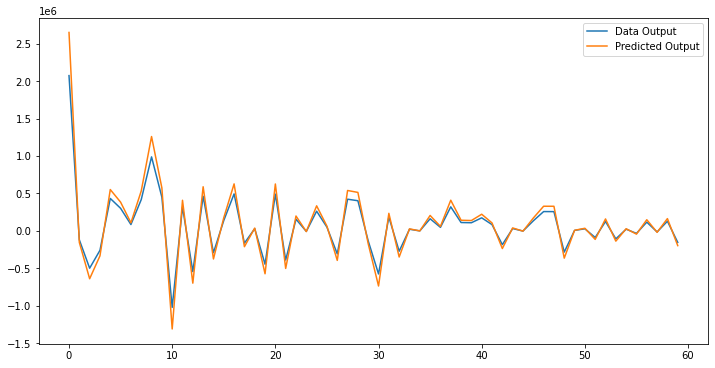

Loss between predicted output and actual output (Both Normalised) 0.1551698974358954


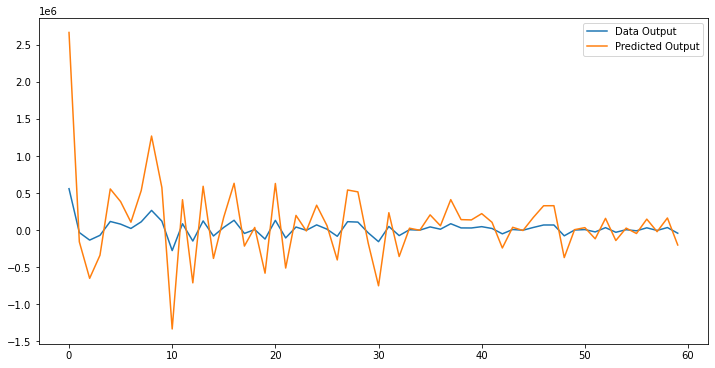

Loss between predicted output and actual output (Both Normalised) 0.0002544276344459769


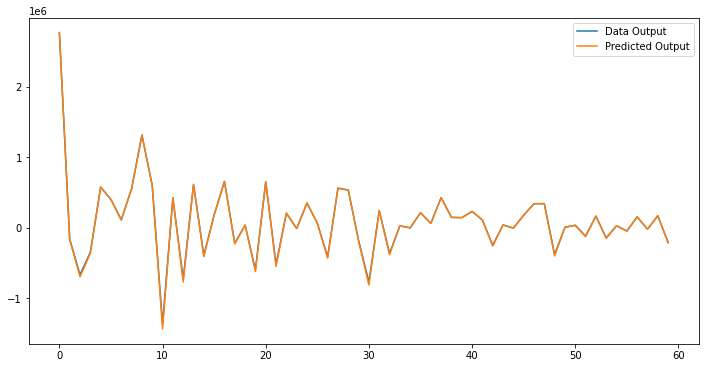

Loss between predicted output and actual output (Both Normalised) 0.0006766638127067971


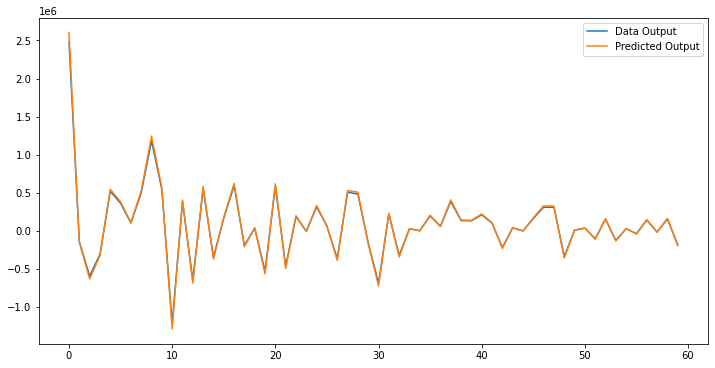

Loss between predicted output and actual output (Both Normalised) 0.08939118927581875


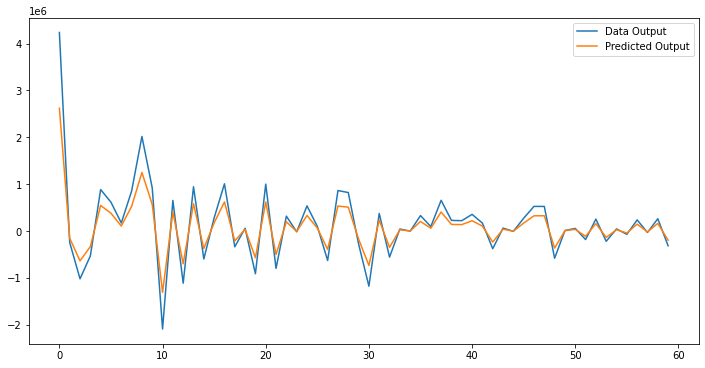

Loss between predicted output and actual output (Both Normalised) 0.15384018277659375


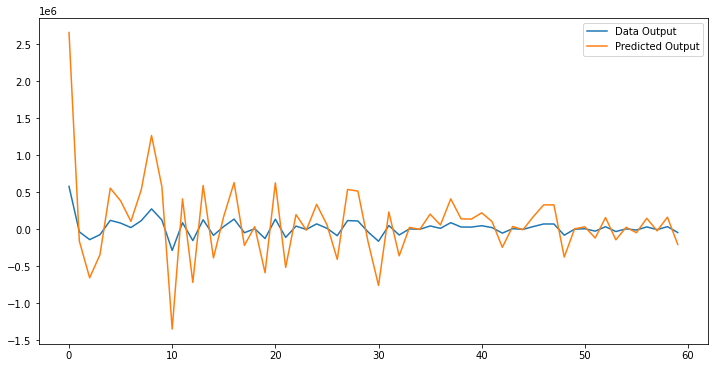

Loss between predicted output and actual output (Both Normalised) 0.14642904151602915


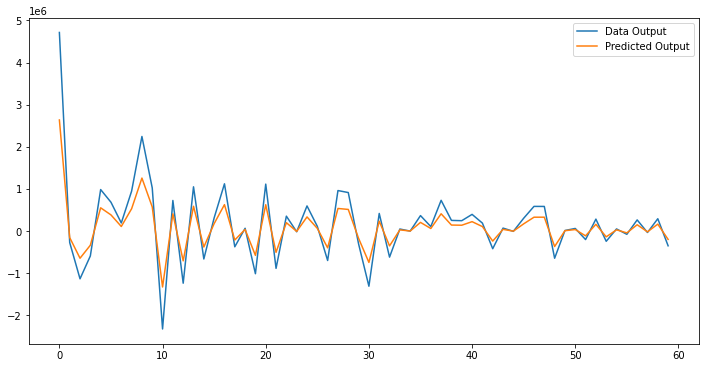

Loss between predicted output and actual output (Both Normalised) 0.06681084466715782


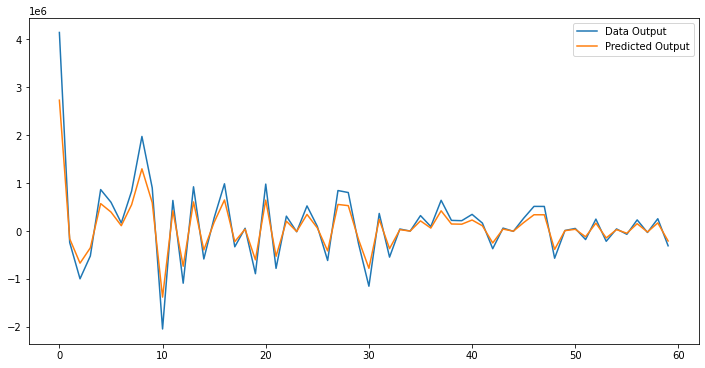

In [17]:
# Testing for a complete batch in the test dataset using the best model

model.load_state_dict(torch.load('geoid_model_best.pth'))
testing_criterion = nn.MSELoss()

test_input, test_output = next(iter(geoid_test_loader))
for i in range(batch_size):    
    test_index = i
    test_input_batch_sample = test_input[test_index]
    test_output_batch_sample = test_output[test_index]
    predicted_output = model(test_input_batch_sample)
    
    loss = testing_criterion(test_output_batch_sample, predicted_output)
    print("Loss between predicted output and actual output (Both Normalised)",loss.item())
    
    #print(scaler.inverse_transform([predicted_output.detach().numpy()])[0])
    
    plt.figure(figsize=(12, 6))

    plt.plot(scaler.inverse_transform([test_output_batch_sample.detach().numpy()])[0], label='Data Output')
    plt.plot(scaler.inverse_transform([predicted_output.detach().numpy()])[0], label='Predicted Output')
    plt.legend()

    plt.show()

In [18]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

fc1.weight tensor([[ 0.0461,  0.0502, -0.0162,  ..., -0.0177, -0.0579,  0.0363],
        [-0.0496,  0.0252,  0.0221,  ..., -0.0615,  0.0152, -0.0518],
        [-0.0332, -0.0456,  0.0606,  ..., -0.0393,  0.0625,  0.0247],
        ...,
        [ 0.0015,  0.0225, -0.0306,  ...,  0.0202, -0.0394,  0.0433],
        [-0.0179, -0.0515, -0.0172,  ..., -0.0006,  0.0275, -0.0231],
        [-0.0047,  0.0565,  0.0596,  ..., -0.0270,  0.0188,  0.0233]])
fc1.bias tensor([-0.0800, -0.0690, -0.0524,  ..., -0.0808,  0.1230, -0.0130])
fc2.weight tensor([[-0.0190, -0.0323, -0.0005,  ..., -0.0214, -0.0128, -0.0264],
        [ 0.0104, -0.0013,  0.0069,  ...,  0.0213,  0.0059, -0.0195],
        [ 0.0275,  0.0276, -0.0024,  ..., -0.0241, -0.0004, -0.0036],
        ...,
        [ 0.0142,  0.0175, -0.0017,  ...,  0.0078, -0.0239, -0.0073],
        [ 0.0191, -0.0132, -0.0230,  ...,  0.0122,  0.0211, -0.0290],
        [-0.0187, -0.0188, -0.0277,  ..., -0.0063, -0.0012, -0.0162]])
fc2.bias tensor([ 1.0785e-01,  6